In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [3]:
import os
import pandas as pd
import shutil

# Paths
base_dir = './detection_tunisian_food'
csv_file = os.path.join(base_dir, '_annotations.csv')
image_dir = os.path.join(base_dir, 'valid')  # Assuming images are in 'test'

# Load the CSV file
df = pd.read_csv('./detection_tunisian_food/valid/_annotations.csv')


# Create directories for each class
class_names = df['class'].unique()
for class_name in class_names:
    class_dir = os.path.join(base_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

# Move images to respective class folders
for _, row in df.iterrows():
    filename = row['filename']
    class_name = row['class']
    src_path = os.path.join(image_dir, filename)
    dest_path = os.path.join(base_dir, class_name, filename)
    
    # Check if the file exists before moving
    if os.path.exists(src_path):
        shutil.move(src_path, dest_path)
    else:
        print(f"File not found: {src_path}")

print("Images have been organized into class folders.")


File not found: ./detection_tunisian_food\valid\recipe_image_9_12_jpg.rf.00629e519f18860ec5413901ae60ef0e.jpg
File not found: ./detection_tunisian_food\valid\images-5-_jpeg.rf.05d093ba9376b96ca452f3b165876f0a.jpg
File not found: ./detection_tunisian_food\valid\recipe_image_14_15_jpg.rf.30189aea4fad1c2b80c3438b73fbffd4.jpg
File not found: ./detection_tunisian_food\valid\Baklawa-facile_jpg.rf.3d974c3e09ab69cc774a0c7534a8e78b.jpg
File not found: ./detection_tunisian_food\valid\recipe_image_9_96_jpg.rf.8e24cdbde809dee8e5c6451b5dd247cb.jpg
File not found: ./detection_tunisian_food\valid\recipe_image_9_96_jpg.rf.8e24cdbde809dee8e5c6451b5dd247cb.jpg
File not found: ./detection_tunisian_food\valid\6_jpeg.rf.9249ca9bba69f9228529d829097259ab.jpg
File not found: ./detection_tunisian_food\valid\frecasee_jpeg.rf.9dba78161833e1474410e00e7a370134.jpg
File not found: ./detection_tunisian_food\valid\498382_jpg.rf.a5638d372dc69d7f3a9ba3c778becce2.jpg
File not found: ./detection_tunisian_food\valid\49838

In [8]:
# Define directories
train_dir = './detection_tunisian_food/train'
valid_dir = './detection_tunisian_food/valid'
test_dir = './detection_tunisian_food/test'

# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 1035 images belonging to 14 classes.
Found 219 images belonging to 14 classes.


In [12]:
# Définir les chemins
base_dir = './detection_tunisian_food'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Générateurs de données avec augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Créer les générateurs
train_data = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical'
)

valid_data = valid_datagen.flow_from_directory(
    valid_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical'
)


Found 1035 images belonging to 14 classes.
Found 219 images belonging to 14 classes.
Found 143 images belonging to 14 classes.


In [9]:
# Load MobileNetV2 without top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 11s 1us/step


In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=valid_generator.samples // BATCH_SIZE
)

# Save the initial model
model.save('mobilenetv2_tunisian_food.h5')


c:\Users\Zhome\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.3853 - loss: 2.0774

c:\Users\Zhome\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.3888 - loss: 2.0635 - val_accuracy: 0.2188 - val_loss: 3.7755
Epoch 2/10
 1/32 ━━━━━━━━━━━━━━━━━━━━ 17s 566ms/step - accuracy: 0.5625 - loss: 1.1149

c:\Users\Zhome\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5625 - loss: 1.1149 - val_accuracy: 0.2593 - val_loss: 3.3319
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.7022 - loss: 0.8675 - val_accuracy: 0.2969 - val_loss: 4.5961
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8125 - loss: 0.7286 - val_accuracy: 0.4815 - val_loss: 3.5430
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.8084 - loss: 0.5855 - val_accuracy: 0.3385 - val_loss: 4.8538
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9375 - loss: 0.3797 - val_accuracy: 0.4074 - val_loss: 4.1379
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.8587 - loss: 0.4168 - val_accuracy: 0.3438 - val_loss: 5.4450
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.9375 - loss: 0.2065 - val_accuracy: 0.5185 - val_loss: 3.5328
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8856 - loss: 0.3422 - val_accuracy: 0.3594 - val_loss: 5.4415

In [11]:
# Unfreeze the top layers of the base model
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=valid_generator.samples // BATCH_SIZE
)

# Save the fine-tuned model
model.save('mobilenetv2_tunisian_food_finetuned.h5')


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.7897 - loss: 0.6475 - val_accuracy: 0.3854 - val_loss: 6.0480
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9375 - loss: 0.3063 - val_accuracy: 0.2963 - val_loss: 6.9025
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9127 - loss: 0.2626 - val_accuracy: 0.3542 - val_loss: 7.2264
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9062 - loss: 0.2305 - val_accuracy: 0.4074 - val_loss: 5.0075
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9648 - loss: 0.1478 - val_accuracy: 0.4167 - val_loss: 7.0596
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9062 - loss: 0.2444 - val_accuracy: 0.2963 - val_loss: 8.4632
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9670 - loss: 0.1026 - val_accuracy: 0.3802 - val_loss: 7.8397
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9375 - loss: 0.1585 - val_accuracy: 0.4815 - val_l

In [13]:
# Load test data
data_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,  # More rotation
    width_shift_range=0.3,  # Larger shift range
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,  # Stronger zoom
    horizontal_flip=True,
    vertical_flip=True,  # Add vertical flip
    fill_mode='nearest'
)


# Evaluate
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f'Test Accuracy: {test_acc:.2f}')


Found 143 images belonging to 14 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - accuracy: 0.2635 - loss: 9.9540  
Test Accuracy: 0.38


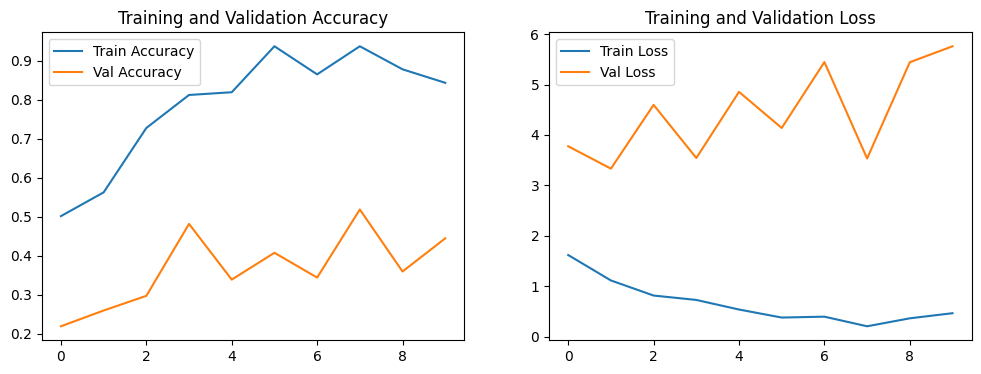

In [14]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()
